# Car Price Prediction
- 데이콘 Basic 자동차 가격 예측 AI 경진대회
- 알고리즘 | 정형 | 회귀 | 산업| MAE

## 1. 패키지 설치

In [1]:
# !pip install catboost

### 1-1. 필요한 라이브러리

In [2]:
import os
import random

import pandas as pd
import numpy as np

# 시각화
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

from catboost import CatBoostRegressor
from xgboost import XGBRegressor

import warnings
warnings.filterwarnings(action='ignore')

plt.rc('font', family='NanumGothic')
plt.rcParams['axes.unicode_minus'] = False

%matplotlib inline

In [3]:
print('numpy version: {}'.format(np.__version__))
print('pandas version: {}'.format(pd.__version__))
print('matplotlib version: {}'.format(matplotlib.__version__))
print('scikit-learn version: {}'.format(sklearn.__version__))

numpy version: 1.22.4
pandas version: 1.5.3
matplotlib version: 3.7.1
scikit-learn version: 1.2.2


### 1-2. 시드 고정

In [4]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42)

## 2. 데이터 전처리

### 2-1. 데이터 불러오기

In [5]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [6]:
train.head()

,ID,생산년도,모델출시년도,브랜드,차량모델명,판매도시,판매구역,주행거리,배기량,압축천연가스(CNG),경유,가솔린,하이브리드,액화석유가스(LPG),가격
0,TRAIN_00000,2018,2014,skoda,fabia,KAT,SLA,85231,999,0,0,1,0,0,51.74
1,TRAIN_00001,2010,2006,toyota,auris,RKO,SWI,135000,1598,0,0,1,0,0,41.47
2,TRAIN_00002,2002,2002,mercedes-benz,clk-klasa,GNI,WIE,255223,1796,0,0,1,0,0,17.81
3,TRAIN_00003,2006,2001,nissan,x-trail,EHX,WIE,238000,2184,0,1,0,0,0,18.20
4,TRAIN_00004,2007,2007,fiat,bravo,OSW,MAL,251000,1910,0,1,0,0,0,17.55


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57920 entries, 0 to 57919
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ID           57920 non-null  object 
 1   생산년도         57920 non-null  int64  
 2   모델출시년도       57920 non-null  int64  
 3   브랜드          57920 non-null  object 
 4   차량모델명        57920 non-null  object 
 5   판매도시         57920 non-null  object 
 6   판매구역         57920 non-null  object 
 7   주행거리         57920 non-null  int64  
 8   배기량          57920 non-null  int64  
 9   압축천연가스(CNG)  57920 non-null  int64  
 10  경유           57920 non-null  int64  
 11  가솔린          57920 non-null  int64  
 12  하이브리드        57920 non-null  int64  
 13  액화석유가스(LPG)  57920 non-null  int64  
 14  가격           57920 non-null  float64
dtypes: float64(1), int64(9), object(5)
memory usage: 6.6+ MB


### 2-2. 이상치 제거
- Train dataset를 시각화하여 데이터의 이상치를 제거함
- <u>주행거리 컬럼</u>에서 유독 큰 값 하나를 제거함(이상치 제거 전보다 후가 성능이 약간 더 좋았음!)

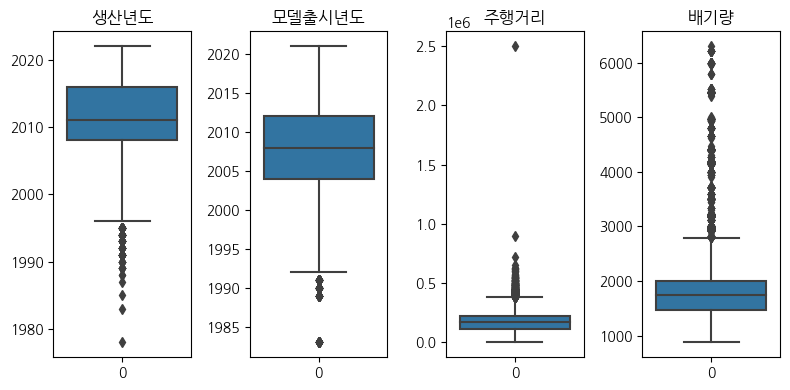

In [8]:
num_features = ['생산년도', '모델출시년도', '주행거리', '배기량']

plt.figure(figsize=(8, 4))
for idx, feature in enumerate(num_features):
    plt.subplot(1, 4, idx+1)
    sns.boxplot(train[feature])
    plt.title(f'{feature}')
plt.tight_layout()
plt.show()

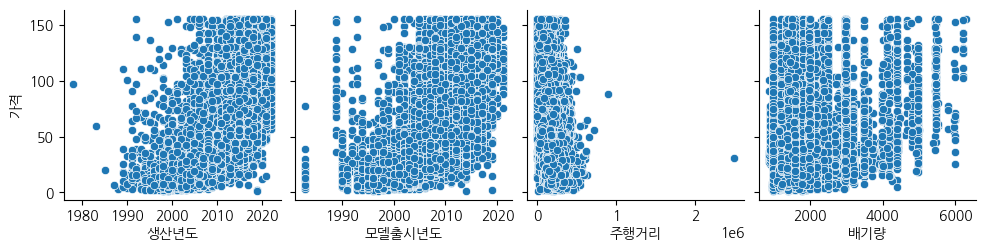

In [9]:
sns.pairplot(data=train, x_vars=['생산년도', '모델출시년도', '주행거리', '배기량'], y_vars='가격');

In [10]:
# 이상치(outlier) 처리
outlier_idx_list = list(train.loc[train['주행거리'] > 2000000].index)
print('이상치 인덱스 리스트: ', outlier_idx_list)

train.drop(outlier_idx_list, inplace=True)
train = train.reset_index(drop=True)

이상치 인덱스 리스트:  [40808]


### 2-3. 데이터셋 생성
- train dataset과 test dataset 준비

In [11]:
train_x = train.drop(['ID', '가격'], axis=1)
train_y = train['가격']

test_x = test.drop(['ID'], axis=1)

### 2-4. Label Encoding
- 범주형 데이터에 대한 인코딩: 라벨 인코딩

In [12]:
cate_features = ['브랜드', '차량모델명', '판매도시', '판매구역']

for feature in cate_features:
    le = LabelEncoder()
    le = le.fit(train_x[feature])
    train_x[feature] = le.transform(train_x[feature])

    for label in np.unique(test_x[feature]):
        if label not in le.classes_:
            le.classes_ = np.append(le.classes_, label)
    test_x[feature] = le.transform(test_x[feature])

## 3. Model Training
- 모델 튜닝 전, 다양한 회귀모델의 성능을 확인한 결과 xgboost 모델과 catboost 모델의 성능이 좋다는 것을 확인함
- <U>모델 하이퍼파라미터 튜닝</U>: xgboost 모델과 catboost 모델 각각 **Optuna**를 통해 최적의 하이퍼파라미터를 찾음

### 3-1. Xgboost 모델 학습

In [13]:
X_data = train_x.copy()
y_data = train_y.copy()

In [14]:
# Fold 정의
N_FOLDS = 10
kf = KFold(n_splits=N_FOLDS, shuffle=True, random_state=42)

y_preds_xgb = np.zeros(len(test_x))
mae_sum_xgb = 0.0
for n_fold, (train_idx, valid_idx) in enumerate(kf.split(X_data)):
    print(f'Fold: {n_fold+1}, Train set: {len(train_idx)}, Validation set: {len(valid_idx)}')
    X_train, X_valid = X_data.iloc[train_idx], X_data.iloc[valid_idx]
    y_train, y_valid = y_data[train_idx], y_data[valid_idx]

    params_xgb = {'max_depth': 12,
                  'n_estimators': 956,
                  'eta': 0.014791920155156192,
                  'subsample': 0.9,
                  'colsample_bytree': 0.6,
                  'colsample_bylevel': 0.9,
                  'min_child_weight': 0.051197391775363685,
                  'reg_lambda': 4.113051928457835,
                  'reg_alpha': 0.022393646278497232,
                  'gamma': 0.012665345770150027,
                  'random_state': 42}

    model_xgb = XGBRegressor(**params_xgb)

    model_xgb.fit(X_train, y_train,
              eval_set=[(X_valid, y_valid)],
              eval_metric='mae',
              early_stopping_rounds=50,
              verbose=False)

    mae = mean_absolute_error(y_valid, model_xgb.predict(X_valid))
    mae_sum_xgb += mae
    print('MAE score:', mae)
    print('==========================================================')

    y_preds_xgb += model_xgb.predict(test_x) / N_FOLDS

print('Avg MAE score:', mae_sum_xgb / N_FOLDS)

Fold: 1, Train set: 52127, Validation set: 5792
MAE score: 5.7298630529428065
Fold: 2, Train set: 52127, Validation set: 5792
MAE score: 5.615904200552906
Fold: 3, Train set: 52127, Validation set: 5792
MAE score: 5.54928119899983
Fold: 4, Train set: 52127, Validation set: 5792
MAE score: 5.624653177748727
Fold: 5, Train set: 52127, Validation set: 5792
MAE score: 5.695394521596024
Fold: 6, Train set: 52127, Validation set: 5792
MAE score: 5.498604089449782
Fold: 7, Train set: 52127, Validation set: 5792
MAE score: 5.771820063989465
Fold: 8, Train set: 52127, Validation set: 5792
MAE score: 5.863116554021835
Fold: 9, Train set: 52127, Validation set: 5792
MAE score: 5.838953091742584
Fold: 10, Train set: 52128, Validation set: 5791
MAE score: 5.52313002950971
Avg MAE score: 5.671071998055367


### 3-2. Catboost 모델 학습

In [15]:
X_data = train_x.copy()
y_data = train_y.copy()

In [16]:
# Fold 정의
N_FOLDS = 10
kf = KFold(n_splits=N_FOLDS, shuffle=True, random_state=42)

y_preds_cb = np.zeros(len(test_x))
mae_sum_cb = 0.0
for n_fold, (train_idx, valid_idx) in enumerate(kf.split(X_data)):
    print(f'Fold: {n_fold+1}, Train set: {len(train_idx)}, Validation set: {len(valid_idx)}')
    X_train, X_valid = X_data.iloc[train_idx], X_data.iloc[valid_idx]
    y_train, y_valid = y_data[train_idx], y_data[valid_idx]

    params_cb = {'n_estimators': 994,
                 'max_depth': 10,
                 'learning_rate': 0.0693264744306012,
                 'l2_leaf_reg': 0.001112702395533202,
                 'subsample': 0.9746213946357353,
                 'colsample_bylevel': 0.9770506869911889,
                 'min_child_samples': 92,
                 'random_state': 42,
                 'eval_metric': 'MAE'}

    model_cb = CatBoostRegressor(**params_cb)

    model_cb.fit(X_train, y_train,
                 eval_set=[(X_valid, y_valid)],
                 early_stopping_rounds=100,
                 verbose=100)

    mae = mean_absolute_error(y_valid, model_cb.predict(X_valid))
    mae_sum_cb += mae
    print('MAE score:', mae)
    print('==============================================================================')

    y_preds_cb += model_cb.predict(test_x) / N_FOLDS

print('Avg MAE score:', mae_sum_cb / N_FOLDS)

Fold: 1, Train set: 52127, Validation set: 5792
0:	learn: 27.3722321	test: 27.4544567	best: 27.4544567 (0)	total: 86.9ms	remaining: 1m 26s
100:	learn: 6.7964130	test: 7.0377541	best: 7.0377541 (100)	total: 3.08s	remaining: 27.2s
200:	learn: 5.9790897	test: 6.4007198	best: 6.4007198 (200)	total: 5.95s	remaining: 23.5s
300:	learn: 5.5330145	test: 6.1590248	best: 6.1590248 (300)	total: 11s	remaining: 25.4s
400:	learn: 5.2140603	test: 6.0389265	best: 6.0372573 (397)	total: 13.9s	remaining: 20.6s
500:	learn: 4.9679785	test: 5.9656031	best: 5.9656031 (500)	total: 16.8s	remaining: 16.5s
600:	learn: 4.7660783	test: 5.9180085	best: 5.9180085 (600)	total: 19.6s	remaining: 12.8s
700:	learn: 4.5806267	test: 5.8892137	best: 5.8888741 (699)	total: 24.4s	remaining: 10.2s
800:	learn: 4.4188147	test: 5.8662568	best: 5.8662568 (800)	total: 27.5s	remaining: 6.63s
900:	learn: 4.2698458	test: 5.8597625	best: 5.8575465 (871)	total: 30.4s	remaining: 3.14s
993:	learn: 4.1456846	test: 5.8495282	best: 5.8486219

# 4. Submission

### 4-1. 앙상블(Ensemble)

In [17]:
submission = pd.read_csv('sample_submission.csv')

In [18]:
submission['가격'] = (0.7 * y_preds_xgb + 0.3 * y_preds_cb).round(2)
submission.head()

,ID,가격
0,TEST_00000,86.30
1,TEST_00001,25.92
2,TEST_00002,87.16
3,TEST_00003,125.57
4,TEST_00004,47.87


In [19]:
submission.to_csv('submission.csv', index = False)